
## Step 0: Load The Data

In [3]:
# Load pickled data
import numpy as np
import pickle

training_file = "sign_train.p"
validation_file= "sign_valid.p"
testing_file = "sign_test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

    
    
X_train_color, y_train = train['features'], train['labels']
X_valid_color, y_valid = valid['features'], valid['labels']
X_test_color, y_test = test['features'], test['labels']



---

## Dataset Explanation (Not Required To Understand Model)

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. The coordinates represent the pixels in the original, non resized (non 32x32) image. 

### Basic Summary of the Data Set

In [4]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train_color.shape[0]

# TODO: Number of validation examples
n_validation = X_valid_color.shape[0]

# TODO: Number of testing examples.
n_test = X_test_color.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = [X_train_color.shape[1],X_train_color.shape[2]]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = 1-min(y_train) + max(y_train)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = [32, 32]
Number of classes = 43


### Pre-processing the Data Set  (Grayscale, Equalized Histogram, Normalization)

First the images are set to grayscale. While this means that color information is lost, it makes the model simpler to train. This is really only relavant given that the LeNet arcetecture was designed and optimized for grayscale. This means that setting it up to handle color images would require much more testing than simply using grayscale.

Second the images use equalized histogram to "brighten" them up. Essentially, pictures don't always take up the whole range of color. For darker pictures this can make the images harder to detect (for a human). Equalized Histogram makes an image take up the entire color space in such a way if you were to sum up the counts of each color(0-255), that sum would increase linearly.

# Todo Add Pics

Lastly the images are normalized (set to 0 mean and divided by standard deviation) to make the model easier to train

In [5]:
from sklearn.utils import shuffle
import cv2
#normalization is done in LeNet
def normalize(x):
    return (x-128.0)/128.0

import copy 
def getGrayscale(x):
    images = [cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) for img in x]  
    return np.array(images)

def getEqualHist(x):
    images = [cv2.equalizeHist(img) for img in x]
    return np.array(images)

def processData(x):
    
    gray = getGrayscale(x)
    data = gray[:,:,:,None]
    #hist = getEqualHist(gray)
    #data = np.concatenate((gray[:,:,:,None],hist[:,:,:,None],x),3)
    

    return data

#Shuffle data
from sklearn.utils import shuffle
X_train_color, y_train = shuffle(X_train_color, y_train)

#Add a grayscale "channel"

print(X_train_color.shape)
X_train = processData(X_train_color)
X_valid = processData(X_valid_color)
X_test = processData(X_test_color)

print(" Train Shape: ", X_train.shape,"\n Validation Shape: ",X_valid.shape,"\n Test Shape: ",X_test.shape,"\n")

(34799, 32, 32, 3)
 Train Shape:  (34799, 32, 32, 1) 
 Validation Shape:  (4410, 32, 32, 1) 
 Test Shape:  (12630, 32, 32, 1) 



### Display Data

In [6]:
import random
import matplotlib.pyplot as plt
import csv
%matplotlib inline

def load_sign_names(file):
    sign_name = [0 for x in range(n_classes)]
    with open(file) as f:

        for row in f:
            data = [x for x in row.split(',')]
            if data[0][0] != 'C':
                sign_name[int(data[0])] = data[1]
    return sign_name

def three_channel_gray(gray):
    gray = gray[:,:,None]
    return np.concatenate((gray,gray,gray),2)

### Visualization

Below is a visualization of the dataset. It includes 3 images of each class, as well as how those images are modified to be fed into the network

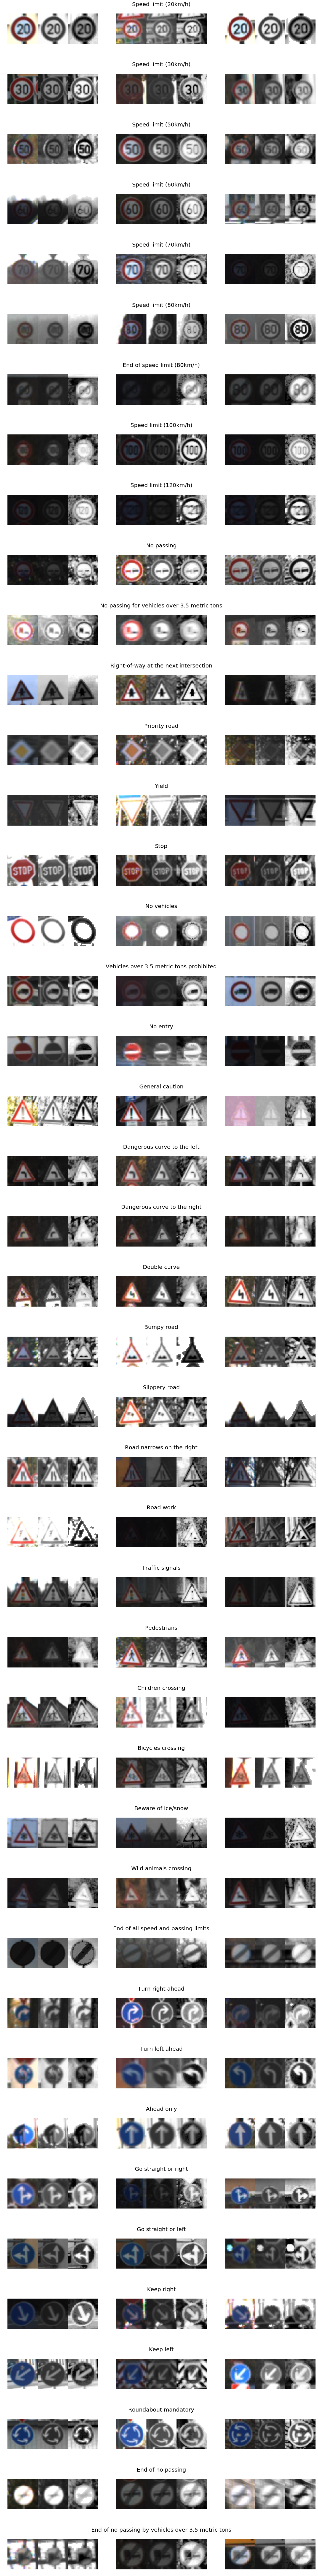

In [12]:
sign_names = load_sign_names('signnames.csv')
fig, axs = plt.subplots(n_classes,3, figsize=(20,4*n_classes))
axs = axs.ravel()
for i in range(n_classes):
    count = 0
    for j in range(len(y_train)):
        if count >=3:
            break
        if y_train[j] == i:
            
            show_color = X_train_color[j]
            gray_temp = cv2.cvtColor(X_train_color[j],cv2.COLOR_RGB2GRAY)
            show_gray = three_channel_gray(gray_temp).squeeze()
            show_hist = three_channel_gray(cv2.equalizeHist(gray_temp)).squeeze()
            show_all = np.hstack((show_color,show_gray,show_hist))
            
            #Image plot number
            pn = i*3+count
            axs[pn].axis('off')
            axs[pn].imshow(np.array(show_all))
            
            if count == 1:
                axs[pn].set_title(sign_names[i],fontsize=20)
            else:  
                axs[pn].set_title("")
                
            count += 1


### Model Architecture

I have simply used the LeNet Architecture

In [19]:
import tensorflow as tf

EPOCHS = 25
BATCH_SIZE = 128

from tensorflow.contrib.layers import flatten
    
def LeNet(x):  
    
    x = normalize(x)
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.12
    valid = 'VALID'
    
    
    c1_out = 6
    c2_out = 16
    c3_out = 400
    fc1_out = n_classes
    fc2_out = 108
    num_labels = n_classes #43 for sign data
    
    input_shape = x.get_shape()
    # Layer 1 - 32x32x1 -> 28x28x6 -> 14x14x6
    
    #Init weights / bias
    c1_w = tf.Variable(tf.truncated_normal(shape = (5,5,int(input_shape[3]),c1_out), mean = mu, stddev = sigma), name = "c1_w")
    c1_b = tf.Variable(tf.zeros(c1_out), name = "c1_b")
    
    #c1 conv
    c1 = tf.nn.conv2d(x,c1_w, strides = [1,1,1,1], padding = valid) + c1_b
    #c1 activation
    
    c1 = tf.nn.relu(c1)
    c1 = tf.nn.dropout(c1,conv_keep_prob)
    #c1 pooling 28x28x6 -> 14x14x6
    c1 = tf.nn.max_pool(c1,ksize = [1,2,2,1],strides = [1,2,2,1], padding = valid)
    
    
    # Layer 2 - 14x14x6 -> 10x10x16 -> 5x5x16
    
    #Init weights / bias
    c2_w = tf.Variable(tf.truncated_normal(shape =(5,5,c1_out,c2_out), mean = mu, stddev = sigma), name = "c2_w")
    c2_b = tf.Variable(tf.zeros(c2_out), name = "c2_b")

    #c2 conv
    c2 = tf.nn.conv2d(c1,c2_w, strides = [1,1,1,1], padding = valid) + c2_b
    #c2 activation
    c2 = tf.nn.relu(c2)
    #c2 pooling 10x10x16 -> 5x5x16
    c2 = tf.nn.max_pool(c2,ksize = [1,2,2,1],strides = [1,2,2,1], padding = valid)
    
    

    c3_w = tf.Variable(tf.truncated_normal(shape=(5, 5, c2_out, c3_out), mean = mu, stddev = sigma, name="c3_w"))
    c3_b = tf.Variable(tf.zeros(400), name="c3_b")
    
    c3 = tf.nn.conv2d(c2,c3_w,strides = [1,1,1,1], padding = valid) + c3_b
    c3 = tf.nn.relu(c3)
    
    
    flat_c2 = flatten(c2)
    flat_c3 = flatten(c3)
    #print(flat_c1.get_shape().as_list())
    #print(flat_c2.get_shape().as_list())
    fc_in = tf.concat(1,[flat_c2,flat_c3])
    fc_in = tf.nn.dropout(fc_in,keep_prob)
                       
    # Layer 3: 900->300
    
    #Init weights / bias
    fc1_w = tf.Variable(tf.truncated_normal(shape = (c3_out+ 5*5*c2_out,fc1_out),mean = mu,stddev = sigma), name = "fc1_w")
    fc1_b = tf.Variable(tf.zeros(fc1_out), name = "fc1_b")
    
    #fc1 logits
    logits = tf.matmul(fc_in,fc1_w) + fc1_b
    #fc1 activation
    
    loss = tf.nn.l2_loss(c1_w) + tf.nn.l2_loss(c2_w) + tf.nn.l2_loss(c3_w) + tf.nn.l2_loss(fc1_w)
    
    return logits,loss

    #fc1 = tf.nn.relu(fc1)
    #fc1 = tf.nn.dropout(fc1,keep_prob)
    
    
    #Layer 4: 120 -> 84
    
    #Init weights / bias
    #fc2_w = tf.Variable(tf.truncated_normal(shape = (fc1_out,fc2_out),mean = mu,stddev = sigma), name = "fc2_w")
    #fc2_b = tf.Variable(tf.zeros(fc2_out), name = "fc2_b")
    
    #fc2 logits

    #fc2 = tf.matmul(fc1,fc2_w) + fc2_b
    #fc2 activation
    #fc2 = tf.nn.relu(fc2)
    #fc2 = tf.nn.dropout(fc2,keep_prob)
    
    #Layer 5: 120 -> 84
    
    #Init weights / bias
    #fc3_w = tf.Variable(tf.truncated_normal(shape = (fc2_out,num_labels),mean = mu,stddev = sigma), name = "fc3_w")
    #fc3_b = tf.Variable(tf.zeros(num_labels), name = "fc3_b")
    
    #fc3 logits
    #fc3 = tf.matmul(fc2,fc3_w) + fc3_b
    
    #logits = fc3

    #l2_loss = tf.nn.l2_loss(c1_w) + tf.nn.l2_loss(c1_w) + tf.nn.l2_loss(fc1_w) + tf.nn.l2_loss(fc2_w) + tf.nn.l2_loss(fc3_w)
    
    #return logits , l2_loss

### Train, Validate and Test the Model

In [20]:
x = tf.placeholder(tf.float32, (None,image_shape[0],image_shape[1],X_train.shape[3]))
y = tf.placeholder(tf.int32, (None))
beta = tf.placeholder(tf.float32)
keep_prob = tf.placeholder(tf.float32)
conv_keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)


rate = 0.0013
logits, loss = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,conv_keep_prob : 1,keep_prob : 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [21]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Training for " + str(EPOCHS) + " epochs with batch size of " + str(BATCH_SIZE))
    print()
    
    max_val_acc = .97 
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        
        test_accuracy = 0
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, conv_keep_prob : 1 , keep_prob : 0.5, beta : 0.04})
            
            
            
        train_accuracy = evaluate(X_train,y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        
        if validation_accuracy > max_val_acc:
            max_val_acc = validation_accuracy
            saver.save(sess, './TrafficNet')
            print("Model saved")
        
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.4f}".format(train_accuracy))
        print("Validation Accuracy = {:.4f}".format(validation_accuracy))
        print("Max Validation Accuracy = {:.4f}".format(max_val_acc))
        print("")
        
        
    saver.save(sess, './savetest')    
    if max_val_acc == .97:
        saver.save(sess, './TrafficNet')
        print("Model saved")
        
        
    


Training for 25 epochs with batch size of 128

EPOCH 1 ...
Train Accuracy = 0.9150
Validation Accuracy = 0.8395
Max Validation Accuracy = 0.9700

EPOCH 2 ...
Train Accuracy = 0.9699
Validation Accuracy = 0.9098
Max Validation Accuracy = 0.9700

EPOCH 3 ...
Train Accuracy = 0.9814
Validation Accuracy = 0.9265
Max Validation Accuracy = 0.9700

EPOCH 4 ...
Train Accuracy = 0.9888
Validation Accuracy = 0.9365
Max Validation Accuracy = 0.9700

EPOCH 5 ...
Train Accuracy = 0.9920
Validation Accuracy = 0.9354
Max Validation Accuracy = 0.9700



KeyboardInterrupt: 

### Test Data with test set

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    final_train = evaluate(X_train, y_train)
    print("Final Train Accuracy = {:.4f}".format(final_train))
    
    final_valid = evaluate(X_valid, y_valid)
    print("Final Valid Accuracy = {:.4f}".format(final_valid))    
    
    final_test = evaluate(X_test, y_test)
    print("Final Test Accuracy = {:.4f}".format(final_test))

---

### Manual Data Tests

The images used to train, validate, and test the model were essentially a black box, given to my network. Below are 5 images I selected to get a more tangible idea of the model. To do this I have also printed out the top 5 predictions that the model makes

### Load and Output the Images

In [ ]:
### Convert PNG to JPG
### https://gist.github.com/qingswu/1a58c9d66dfc0a6aaac45528bbe01b82
from glob import glob                                                           
import cv2 
pngs = glob('test_images/*.png')

for j in pngs:
    img = cv2.imread(j)
    cv2.imwrite(j[:-3] + 'jpg', img)

In [ ]:
### Load Images
import os
image_names = ['no_vehicles','road_work','turn_right','no_entry','bumpy_road']
file_type = ".jpg"
directory = "test_images/"

labels = np.array([15,25,33,17,22])
imgs = []

#Load Images
for filename in image_names:
    
    # Load and resize image
    img = plt.imread(directory+filename+file_type)
    img = cv2.resize(img, (32, 32),interpolation = cv2.INTER_AREA)
    imgs.append(img)

In [ ]:
###Plot Images 
fig, axs = plt.subplots(3 , 5)
axs = axs.ravel()

gray = getGrayscale(imgs)
hist = getEqualHist(gray)


for i in range(len(imgs)):
    
    for j in range(3):
        axs[i+j*5].axis('off')
           
    axs[i].imshow(imgs[i])
    axs[i+5].imshow(three_channel_gray(gray[i]).squeeze())
    axs[i+10].imshow(three_channel_gray(hist[i]).squeeze())

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
import tensorflow as tf

print(hist.shape)
X_custom_test = processData(imgs)
y_custom_test = labels



logits_softmax = tf.nn.softmax(logits)
top_predictions = tf.nn.top_k(logits_softmax, k=5)

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "./savetest")
    #Load Model 
    #saver.restore(sess, tf.train.latest_checkpoint('.'))
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, "./TrafficNet")
    
    """
    saver = tf.train.import_meta_graph('TrafficNet.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    init = tf.global_variables_initializer()
    sess.run(init)
    graph = tf.get_default_graph()
    
    
    c1_w = graph.get_tensor_by_name("c1_w:0")
    c1_b = graph.get_tensor_by_name("c1_b:0")
    c2_w = graph.get_tensor_by_name("c2_w:0")
    c2_b = graph.get_tensor_by_name("c2_b:0")
    fc1_w = graph.get_tensor_by_name("fc1_w:0")
    fc1_b = graph.get_tensor_by_name("fc1_b:0")
    fc2_w = graph.get_tensor_by_name("fc2_w:0")
    fc2_b = graph.get_tensor_by_name("fc2_b:0")
    fc3_w = graph.get_tensor_by_name("fc3_w:0")
    fc3_b = graph.get_tensor_by_name("fc3_b:0")

    """
    feed_dict = {x : X_custom_test, y: y_custom_test, conv_keep_prob : 1, keep_prob : 1}
    output = sess.run(top_predictions, feed_dict = feed_dict)
    
    print(output)
    print(labels.T)
    
    

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.